In [2]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Read in model data 
multi_model = func.read_in_cmip_models('/g/data/eg3/mf3225/CMIP_TS/CMIP6/historical', 'r1i1p1f1', 'ts', '1850-01', '2015-01')
# Order models alphabetically 
multi_model = multi_model.sortby('model')
# Select out surface temperature data 
data = multi_model.ts

In [3]:
# Select out the 20 models that have extreme indices on NCI
keep = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-g3',
        'GFDL-CM4', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6', 'MPI-ESM1-2-HR',
        'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM']

data = data.sel(model=keep)

In [4]:
# Quadratically detrend temp data 
data_dt = xr.apply_ufunc(func.quad_detrend, data, 
                             input_core_dims=[['time']],
                             output_core_dims=[['time']],
                             vectorize=True,
                             dask='parallelized')

data_dt = data_dt.transpose(*data.dims).chunk('auto').sel(time=slice('1900-01', '2014-12'))

In [5]:
# Select out tropical Pacific region and apply land mask 
sst_region = data_dt.sel(lat=slice(-15,15)).sel(lon=slice(140,280))
#Landmask
landmask_ds = xr.open_dataset('/g/data/eg3/pfd548/gridarea/land-sea_mask/fractional_land.1.5-deg.nc')
landmask = landmask_ds.mean(dim='time')
# Apply to tropical Pacific region 
sst_region = sst_region.where(landmask.data==0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into ful

In [6]:
# Calculate anomalies 
clims = sst_region.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anoms = sst_region.groupby('time.month') - clims

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 115 times more chunks
  return self.array[key]


In [7]:
# Calculate EOFs
eofs_list = []
pcs_list = []
var_list = []
for m in anoms.model:
    e, p, v = func.eof_and_pcs(anoms.sel(model=m).chunk({'time':-1, 'lat':-1, 'lon':-1}), 3)
    eofs_list.append(e)
    pcs_list.append(p)
    var_list.append(v)

In [8]:
# Concatenate 
model_eofs = xr.concat(eofs_list, dim='model').chunk('auto')
model_pcs = xr.concat(pcs_list, dim='model').chunk('auto')
model_var = xr.concat(var_list, dim='model').chunk('auto')
# Add model names
model_names = data.model.values
model_eofs = model_eofs.assign_coords(model = model_names)
model_pcs = model_pcs.assign_coords(model = model_names)
model_var = model_var.assign_coords(model = model_names) 

In [9]:
# Save as net cdf
model_eofs.to_netcdf('/g/data/w40/rl5183/CMIP6_20_eofs.nc')
model_pcs.to_netcdf('/g/data/w40/rl5183/CMIP6_20_pcs.nc')
model_var.to_netcdf('/g/data/w40/rl5183/CMIP6_20_var.nc')

In [3]:
eofs = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_eofs.nc')

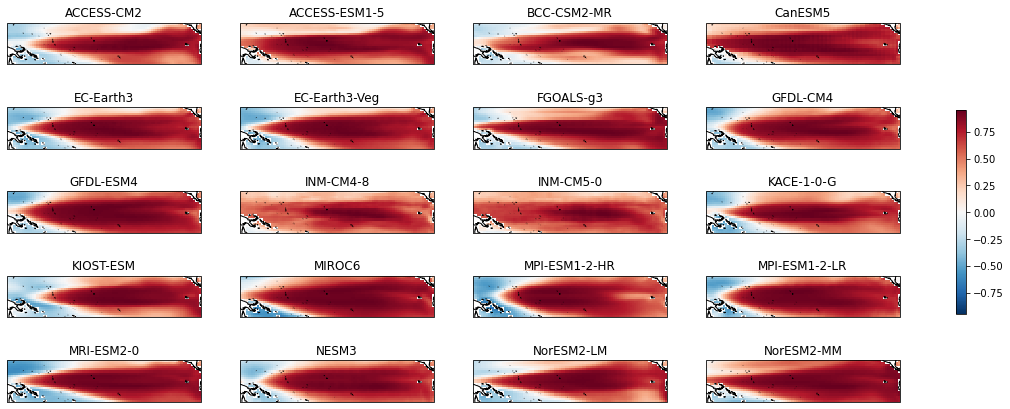

In [20]:
fig = plt.figure(figsize=(20,7.5))
axs = []

columns = 4
rows = 5

#vmin = -0.7
#vmax = 0.3

for i, m in enumerate(eofs.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    d = eofs.sel(mode=0).sel(model=m)
    C = d.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

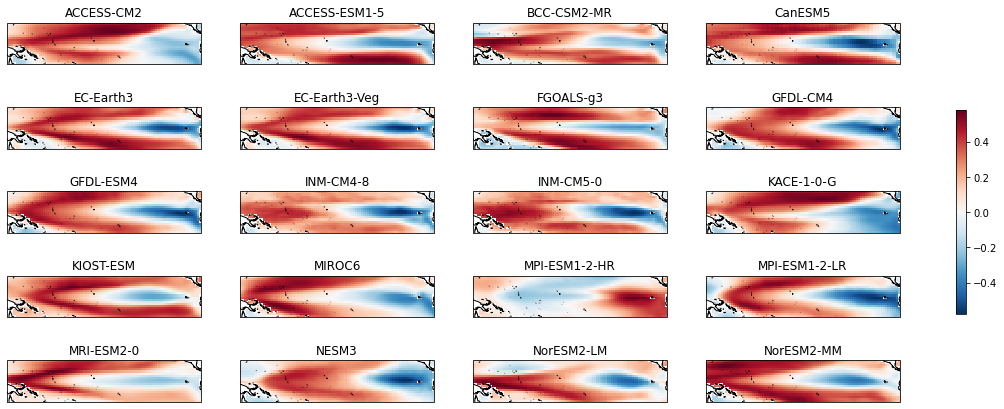

In [21]:
fig = plt.figure(figsize=(20,7.5))
axs = []

columns = 4
rows = 5

#vmin = -0.7
#vmax = 0.3

for i, m in enumerate(eofs.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    d = eofs.sel(mode=1).sel(model=m)
    C = d.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

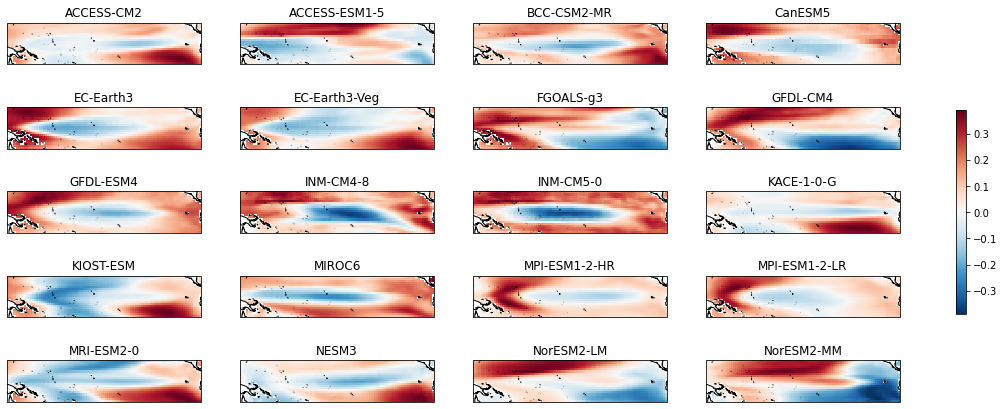

In [22]:
fig = plt.figure(figsize=(20,7.5))
axs = []

columns = 4
rows = 5

#vmin = -0.7
#vmax = 0.3

for i, m in enumerate(eofs.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    d = eofs.sel(mode=2).sel(model=m)
    C = d.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

In [4]:
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-15,15)).sel(lon=slice(140,280)).sel(time=slice('1900-01', '2014-12'))
# Quadtratically Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate anomalies 
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim
# EOFs
had_eof, had_pcs, had_var = func.eof_and_pcs(anom, 3)

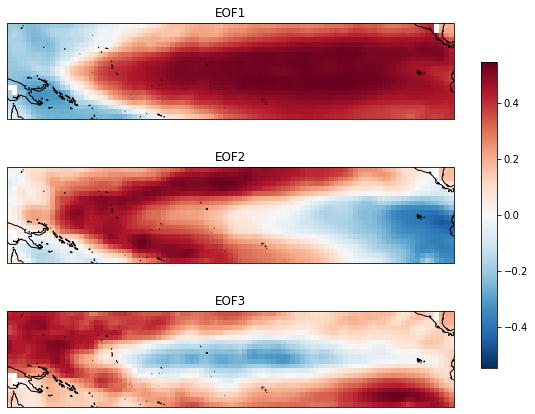

In [28]:
fig = plt.figure(figsize = (10,7.5)) 
axs = []
ax = fig.add_subplot(311, projection=ccrs.PlateCarree(180))
im = (had_eof.sel(mode=0)*(-1)).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EOF1')
axs.append(ax)
ax = fig.add_subplot(312, projection=ccrs.PlateCarree(180))
im = had_eof.sel(mode=1).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EOF2')
axs.append(ax)
ax = fig.add_subplot(313, projection=ccrs.PlateCarree(180))
im = had_eof.sel(mode=2).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EOF3')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)

In [5]:
# Calculate pattern correlations
EOF1_pattern_corr = []
for m in eofs.model:
    EOF1_pattern_corr.append(func.pattern_cor(eofs.sel(mode=0).sel(model=m), had_eof.sel(mode=0)))

EOF2_pattern_corr = []
for m in eofs.model:
    EOF2_pattern_corr.append(func.pattern_cor(eofs.sel(mode=1).sel(model=m), had_eof.sel(mode=1)))
    
EOF2_3_pattern_corr = []
for m in eofs.model:
    EOF2_3_pattern_corr.append(func.pattern_cor(eofs.sel(mode=2).sel(model=m), had_eof.sel(mode=1)))

In [46]:
# Take absolute values 
EOF1_pattern_corr_abs = np.absolute(EOF1_pattern_corr)
EOF2_pattern_corr_abs = np.absolute(EOF2_pattern_corr)
EOF2_3_pattern_corr_abs = np.absolute(EOF2_3_pattern_corr)

In [47]:
# Make pandas dataframe 
model_names = data.model.values
names = list(model_names)

pandas_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], EOF1_pattern_corr_abs[i], EOF2_pattern_corr_abs[i], EOF2_3_pattern_corr_abs[i]]
    pandas_data.append(cell)
    
df = pd.DataFrame(pandas_data, columns=['Model', 'EOF1', 'EOF2', 'EOF2_3'])
df.head()

,Model,EOF1,EOF2,EOF2_3
0,ACCESS-CM2,0.887726,0.920113,0.350636
1,ACCESS-ESM1-5,0.690591,0.555228,0.304928
2,BCC-CSM2-MR,0.830978,0.560440,0.274490
3,CanESM5,0.776073,0.695793,0.082367
4,EC-Earth3,0.933440,0.769141,0.317236


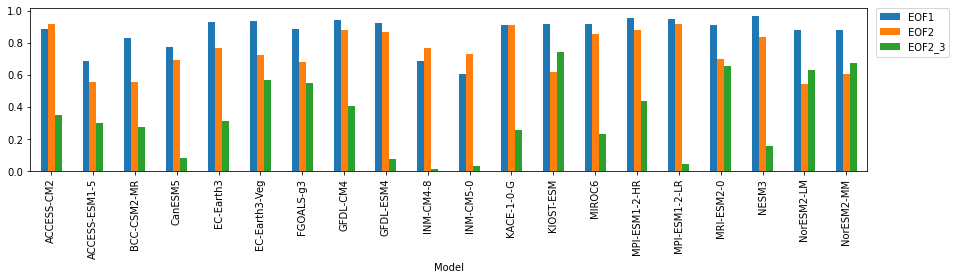

In [48]:
df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))

Pattern correlation between observed EOF2 and modelled EOF3 in higher in three models: KIOST-ESM, NorESM2-LM, and NorESM2-MM

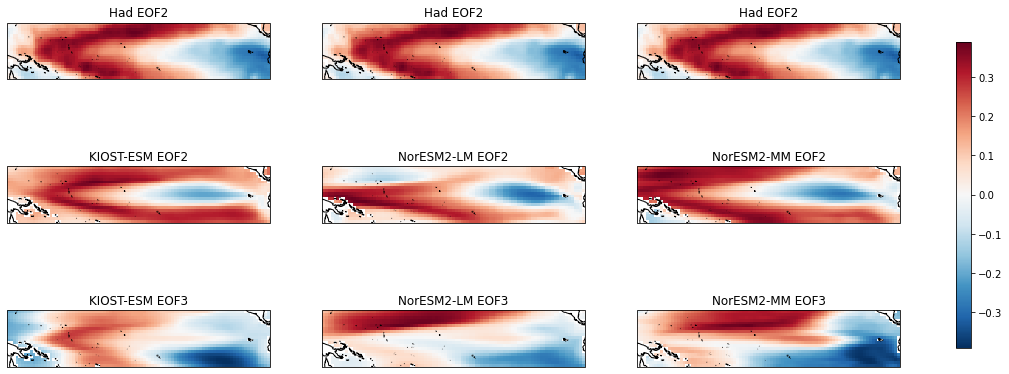

In [59]:
# Plot models where EOF3 has higher pattern corr with observed EOF2 to check 
fig = plt.figure(figsize = (20,7.5)) 
axs = []
# First row (hadISST EOF 2)
ax = fig.add_subplot(331, projection=ccrs.PlateCarree(180))
im = had_eof.sel(mode=1).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Had EOF2')
axs.append(ax)
ax = fig.add_subplot(332, projection=ccrs.PlateCarree(180))
im = had_eof.sel(mode=1).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Had EOF2')
axs.append(ax)
ax = fig.add_subplot(333, projection=ccrs.PlateCarree(180))
im = had_eof.sel(mode=1).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Had EOF2')
axs.append(ax)

# Second row (model EOF 2)
ax = fig.add_subplot(334, projection=ccrs.PlateCarree(180))
im = eofs.sel(mode=1).sel(model='KIOST-ESM').plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('KIOST-ESM EOF2')
axs.append(ax)
ax = fig.add_subplot(335, projection=ccrs.PlateCarree(180))
im = eofs.sel(mode=1).sel(model='NorESM2-LM').plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('NorESM2-LM EOF2')
axs.append(ax)
ax = fig.add_subplot(336, projection=ccrs.PlateCarree(180))
im = (eofs.sel(mode=1)).sel(model='NorESM2-MM').plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('NorESM2-MM EOF2')
axs.append(ax)

# Second row (model EOF 2)
ax = fig.add_subplot(337, projection=ccrs.PlateCarree(180))
im = (eofs.sel(mode=2).sel(model='KIOST-ESM')*-1).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('KIOST-ESM EOF3')
axs.append(ax)
ax = fig.add_subplot(338, projection=ccrs.PlateCarree(180))
im = eofs.sel(mode=2).sel(model='NorESM2-LM').plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('NorESM2-LM EOF3')
axs.append(ax)
ax = fig.add_subplot(339, projection=ccrs.PlateCarree(180))
im = (eofs.sel(mode=2)).sel(model='NorESM2-MM').plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('NorESM2-MM EOF3')
axs.append(ax)

# Colorbar 
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)

Decision to use EOF1 and EOF2 for all models as even though pattern correlations are higher for EOF3 in these three models, EOF2 still looks ok. 